# Simulation-based Calibration in SBI

After a posterior has been trained given a simulation, predictions from this posterior should be made subject to several diagnostical tests. [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) are one such way to "critique" a trained model. Another important approach to such diagnostics is simulation-based calibration as reported by [Talts et al, 2018](https://arxiv.org/abs/1804.06788).

**Simulation-based calibration** (SBC) boils down to a visual (qualitative) way as well as a quantitive measure to check, if the uncertainties obtained from the ensemble of posterior samples meets expectations. In this way, SBC can unveil if the uncertainties of the posterior samples can be considered well calibrated (or healthy if you will). SBC can be used to uncover malignant posteriors. SBC cannot be used to fix this posterior. As such, SBC can be viewed as a necessary condition for a valid inference using a posterior.

## in a nutshell

SBC repeats posterior inference to obtain predicted samples of $x_{true}$ (obtained from $simulator(\theta_{true})$). SBC then ranks these $\theta_{pp}$ with respect to $\theta_{true}$. This rank is calculated by counting those samples $\theta_{pp}$ which fall below $\theta_{true}$. 

### key ideas behind SBC

The core idea behind SBC is two fold: 

- SBC ranks of posterior samples with respect to their ground truth follow a uniform distribution.  
(If the SBC ranks are not uniformly distributed, the posterior is not well calibrated.)

- samples from the data averaged posterior are distributed according to the prior

### What can SBC diagnose?

**SBC can inform us whether we are not wrong.** However, it cannot tell us whether we are right. SBC checks a necessary condition. For example, imagine you run SBC using the prior as a posterior. The ranks would be perfectly uniform. But the inference would be wrong.

**The [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) can be seen as the complementary sufficient check** for the posterior (only as a methaphor, no theoretical guarantees here). Using the prior as a posterior and then doing predictive checks would clearly show that inference failed. 

So SBC can ...

- tell us whether a method produces posterior samples $\theta_{pp}$ that have a systematic negative or positive bias (shift in the mean of the predictions)
- tell us whether a method produces posterior samples $\theta_{pp}$ that are systematically over- or underdispersed (too large or too small variance) 

## a healthy posterior

Let's take the gaussian linear simulation and run inference with (S)NPE on it. As we do not perform any rounds, we actually only do neural posterior estimation (NPE).

In [1]:
import torch
_ = torch.manual_seed(10)
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import check_sbc, run_sbc, get_nltp
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian


In [2]:
num_dim = 2
num_simulations = 5_000

prior_mean = ones(num_dim)
prior_cov = 2*eye(num_dim)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov, validate_args=False)


## An ideal case

To explore SBC, we make our life easy and assume that we deal with a problem where the likelihood is modelled by an identity mapping and a bit of smear. But to start, we only use an almost vanishing smear of `0.01`.

In [3]:

default_likelihood_loc = 0. #let's start with 0 shift
default_likelihood_scale = 0.01 #let's smear theta only by a little bit

def simulator(theta, loc = default_likelihood_loc, scale = default_likelihood_scale):
    """ linear gaussian inspired by sbibm
    s://github.com/sbi-benchmark/sbibm/blob/15f068a08a938383116ffd92b92de50c580810a3/sbibm/tasks/gaussian_linear/task.py#L74
    """
    num_dim = theta.shape[-1]
    cov_ = scale*eye(num_dim) #always positively semi-definite

    # using validate_args=False disables sanity checks on `covariance_matrix`
    # for the sake of speed
    value = MultivariateNormal(loc=(theta+loc), covariance_matrix=cov_, validate_args=False).sample()
    return value

simulator, prior = prepare_for_sbi(simulator, prior)
theta, x = simulate_for_sbi(simulator, prior, num_simulations)


Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
# we define a hold-out sample of 100 to build an observation
theta_holdout = prior.sample((100,))
x_holdout = simulator(theta_holdout)

theta_o = theta_holdout[42,]
x_o = simulator(theta_o)
print("theta:", theta_o.numpy())
print("x    :", x_o.numpy())

theta: [0.68821174 4.186863  ]
x    : [0.69967127 4.3175235 ]


In [5]:
from sbi.utils.get_nn_models import posterior_nn

#we use a mdn model to have a fast turnaround with training
defn = posterior_nn(model='mdn')
inferer = SNPE(prior, density_estimator=defn)

# let's not save the density_estimator in order to do NPE
# (we have enough simulations)
_ = inferer.append_simulations(theta, x).train()

 Training neural network. Epochs trained:  127Neural network successfully converged after 127 epochs.


In [6]:
posterior = inferer.build_posterior()
posterior_samples = posterior.sample((15_000,), x = x_o).detach()
posterior_data = simulator(posterior_samples)


Drawing 15000 posterior samples:   0%|          | 0/15000 [00:00<?, ?it/s]

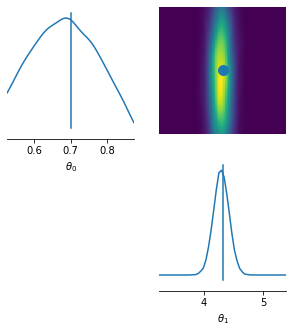

In [7]:
#let's do some posterior predictive checks to see if the
#observation `x_o` remains within the support of the posterior
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=posterior_data,
    points=x_o,
    limits=list(zip(.75*x_o.flatten(), 1.25*x_o.flatten())),
    upper=['kde'],
    diag=['kde'],
    figsize=(5,5),
    labels=[rf"$\theta_{d}$" for d in range(3)]
)

The posterior is well aligned with the observation. On top, the observation falls into the support of the posterior samples. That is indicative that our posterior estimate matches the true posterior very well.

### Running SBC

We have a working and trained posterior at this point! Hurray! Let's look at the SBC metrics now.

In [8]:
num_sbc_runs = 1_000 #the higher sbc runs the better
thetas = prior.sample((num_sbc_runs,)) #we sample again from the prior (as an alternative, we could have used our holdout set)
xs = simulator(thetas) 

In [9]:
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_workers=1)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

`sbi` has established two methods to do simulation-based calibration:

- metrics to compare the sbc ranks with a uniform distribution 
- control plots for visual inspections like fig. 1 or 2 in [Talts et al, 2018](https://arxiv.org/abs/1804.06788)

The `ranks` count per dimension of `theta` how many posterior samples fall below `theta_o`. Based on theory, the distribution of these ranks per dimension of `theta` should turn out to be uniformly distributed. 

The data average posterior `dap` (see equation 1 of [Talts et al, 2018](https://arxiv.org/abs/1804.06788)) is yet another metric of interest. It contains one sample from the estimated posterior obtained from the `xs` above. The `dap` is expected to match the prior distribution used.

In [10]:
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)

The `check_stats` variable created contains a dictionary with 3 metrics that help to judge our posterior. The "first" two compare the ranks to a uniform distribution.

### Ranks versus Uniform distribution

In [11]:
print(f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}")

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [0.40574762 0.04039653]


The Kolmogorov-Smirnov (KS test, see also [here](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test)) as used by `check_sbc` provides p-values `pvals` on the null hypothesis that the samples from `ranks` are drawn from a uniform distribution (in other words `H_0: PDF(ranks) == PDF(uniform)`). We are provided two values as our problem is two-dimensional - one p-value for each dimension. 

The null hypothesis (of both distributions being equal) is rejected if the p-values fall below a significance threshold (usually `< 0.05`). Therefor, vanishing p-values (`ks_pvals=0`) are interpreted to indicate a vanishing false positive rate to (mistakenly) consider both distrubtions being "equal". As we are provided high values of this statistic in dimension 0, samples appear to be from the same distribution, i.e. samples from `ranks` follow a uniform distribution here. The picture is not so clear cut with dimension 1. This merits a second test.

In [12]:
print(f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}")

c2st accuracies 
check_stats['c2st_ranks'] = [0.5905 0.5685]


The second tier of metrics comparing `ranks` with a uniform distributions is a `c2st` test (see [here](http://arxiv.org/abs/1610.06545) for details). This is a nonparametric two sample test based on training a classifier to differented one of the ensembles (`ranks` versus samples from a uniform distribution) by being trained on the other. The values reported are the accuracies from cross-validation. If you see values around `0.5`, the classifier was unable to differentiate both ensembles, i.e. `ranks` are very uniform. If the values are high towards `1`, this matches the case where `ranks` is very unlike a uniform distribution.

### Data averaged posterior (DAP) versus prior

In [13]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

- c2st accuracies check_stats['c2st_dap'] = [0.4775 0.4805]


The last metric reported is again based on `c2st` computed per dimension of `theta`. If you see values around `0.5`, the `c2st` classifier was unable to differentiate both ensembles for each dimension of `theta`, i.e. `dap` are much like (if not identical to) the prior. If the values are very high towards `1`, this represents the case where `dap` is very unlike the prior distribution.

### Visual Inspection

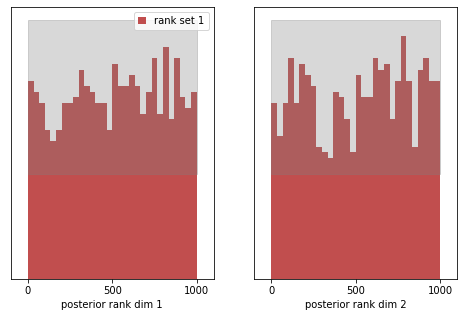

In [14]:
from sbi.analysis.plot import sbc_rank_plot

f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "hist", num_bins=30)

The two plots visualize the distribution of `ranks` (here depicted in red) in each dimension. Highlighted in grey you see the 99% confidence interval of a uniform distribution given the number of samples provided. In plain english: for a uniform distribution, we would expect 1 out of 100 (red) bars to lie outside the grey area.

We also observe, that the entries fluctuate to some degree. This can be considered a hint that `sbc` should be conducted with a lot more samples than 1000.

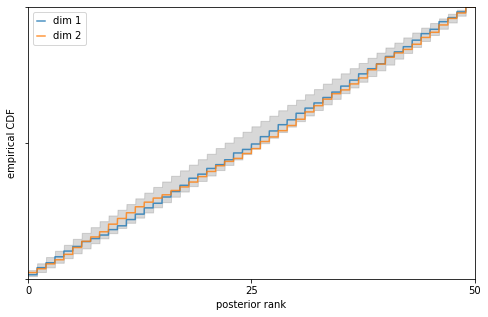

In [15]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "cdf")

The above provides a visual representation of the cumulative density function (CDF) of `ranks` (blue and orange for each dimension of `theta`) with respect to the 95% confidence interval of a uniform distribution (grey).

# When things go haywire

Next, we would like to explore some pathologies visible in sbc plots which can hint at our estimated posterior being somewhat wrong or completely off.

## shifted posterior mean

In this scenario we emulate the situation that our posterior estimates incorrectly with a constant shift. We reuse our trained NPE posterior from above and wrap it so that all samples returned expose a constant shift by `+0.1`.

In [16]:
from utils_13_diagnosis_sbc import BiasedPosterior

# this posterior shifts the expected value of the prior by .1
posterior_ = BiasedPosterior(posterior, shift = .1)



In [17]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_, num_workers=1)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

{'ks_pvals': tensor([0., 0.]), 'c2st_ranks': tensor([0.6745, 0.6780]), 'c2st_dap': tensor([0.5005, 0.5115])}


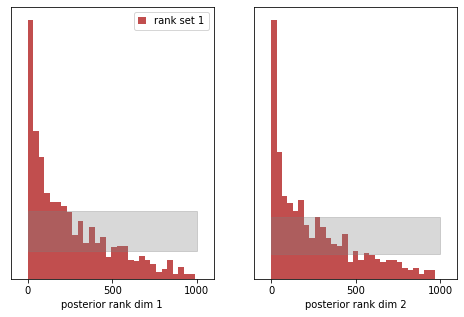

In [18]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "hist", num_bins=30)

We can see that the Kolmogorv-Smirnov p-values vanish, we can reject the hypothesis that the `ranks` PDF is uniform PDF. The c2st accuracies show values higher than `0.5`. This is indicative that something is wrong as it emphasizes again the `ranks` is not a uniform PDF. Let's try to shift all posterior samples in the opposite direction. Because we have shifted the expected value of the posterior to higher values, we see more ranks at low values.

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

{'ks_pvals': tensor([0., 0.]), 'c2st_ranks': tensor([0.6810, 0.6935]), 'c2st_dap': tensor([0.4980, 0.5065])}


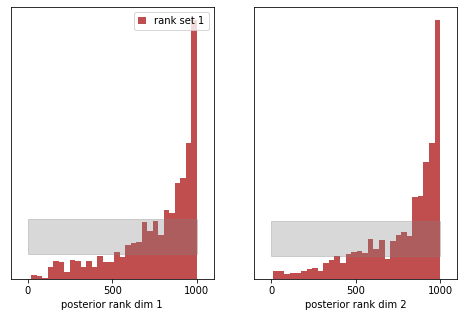

In [19]:
posterior_ = BiasedPosterior(posterior, shift = -.1)
ranks, dap_samples = run_sbc(thetas, xs, posterior_, num_workers=1)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "hist", num_bins=30)

A similar behavior is observed, but this time we see an upshot of ranks to higher values. Because we have shifted the expected value of the posterior to smaller values, we see an upshot in high ranks.
It is interesting to see that the historgams obtained provide very convincing evidence that this is not a uniform distribution. 

## dispersed posterior

In this scenario we emulate the situation if our posterior estimates incorrectly with a dispersion, i.e. the posterior is too wide or too thin. We reuse our trained NPE posterior from above and wrap it so that all samples return a dispersion by 100% more wide (`2`), i.e. the variance is overestimated by a factor of 2.

In [20]:
from utils_13_diagnosis_sbc import DispersedPosterior

# this posterior which disperses the expected posterior value of the prior by 2.
posterior_ = DispersedPosterior(posterior, dispersion = 2.)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

{'ks_pvals': tensor([8.4050e-11, 3.8500e-08]), 'c2st_ranks': tensor([0.5980, 0.6015]), 'c2st_dap': tensor([0.4805, 0.5330])}


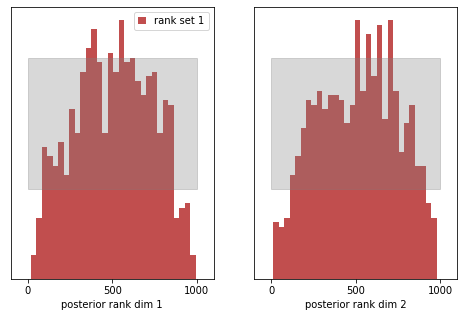

In [21]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_, num_workers=1)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "hist", num_bins=30)

The rank histograms now look more like a very wide gaussian distribution centered in the middle. The KS p-values again vanish unsurprisingly (we must reject the hypothesis that both distributions are from the same uniform PDF) and the c2st_ranks indicate that the rank histogram is not uniform too. As our posterior samples are distributed too broad now, we obtain more "medium" range ranks and hence produce the peak of ranks in the center of the histogram.

We can repeat this exercise by making our posterior too thin, i.e. the variance of the posterior is too small. Let's cut it by half.

In [22]:
posterior_ = DispersedPosterior(posterior, dispersion = .5)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

{'ks_pvals': tensor([1.2161e-08, 1.3010e-10]), 'c2st_ranks': tensor([0.5995, 0.6130]), 'c2st_dap': tensor([0.5045, 0.4835])}


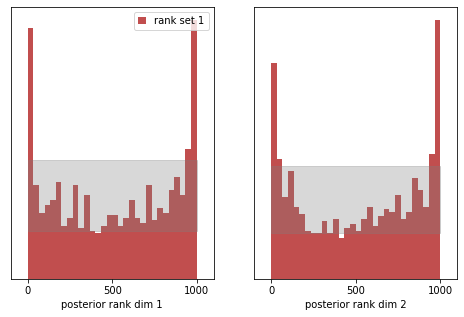

In [23]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_, num_workers=1)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "hist", num_bins=30)

The histogram of ranks now shoots above the allowed (greyed) area for a uniform distributed around the extrema. We made the posterior samples too thin, so we received more extreme counts of ranks. The KS p-values vanish again and the `c2st` metric of the ranks is also larger than `.5` which underlines that our rank distribution is not uniformly distributed.